<a href="https://colab.research.google.com/github/yassmin1/311_services_city_SATX/blob/main/311_SA_EDA_timesereisanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# City of San Antonio’s 311 Service.
----------------------------------------------------
Data is here: https://data.sanantonio.gov/dataset/service-calls.  
---------------------------------------------------    
# **The objective:**
This report provides a snapshot of the 311 service requests received by the City of San Antonio. The data highlights the various types of requests received, response times, and the departments involved in providing services to residents.

----------------------------------------      

# **The Outlines:**  
* Cleaning Data
* Data Analysis and insights
* Geospatial analysis     
* ML models
---------------------------------
# **Dataset:**
311 Service Calls:
311 Customer Service connects citizens with specially-trained customer service representatives ready to assist and facilitate City services including animals, potholes, solid waste collection, property maintenance, downed trees, etc. See more Online Service Requests at
 www.sanantonio.gov/311.    


In [ ]:
from google.colab import drive,userdata
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [ ]:
!pip install mapclassify
!pip install numpy>1.24.1
!pip install scipy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
from shapely.geometry import Point
import geopandas as gpd
import folium
import mapclassify
from folium.plugins import MarkerCluster,HeatMap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


plt.rcParams['figure.figsize'] = (10, 7)
sns.set_theme(font_scale=1.5, style='whitegrid', palette='bright')


In [ ]:
service_file="/content/drive/MyDrive/SanAntonioCity311/all_services_calls.csv"
dic_file="/content/drive/MyDrive/SanAntonioCity311/datadictionary-311.xlsx"



In [ ]:
# dataset Descriptions
dict_data = pd.read_excel(dic_file, skiprows=[0,1],index_col='Field #')
dict_data

,Field Name,Description,Data Type,Comment
Field #,,,,
1,_id,The number for the respective case on the spre...,Text,NaN
2,CATEGORY,This general category was developed to place 3...,Text,There are seven categories with one or more d...
3,CASEID,The unique case reference number is assigned b...,10 numeric characters,NaN
4,OPENEDDATETIME,The date and time that a case was submitted.,mm/dd/yyyy hh:mm:ss AM/PM,NaN
5,SLA_Date,Every service request type has a due date assi...,mm/dd/yyyy hh:mm:ss AM/PM,NaN
6,CLOSEDDATETIME,The date and time that the case/request was wa...,mm/dd/yyyy hh:mm:ss AM/PM,"If there is no closed date, the case is still ..."
7,Late (Yes/No),This indicates whether the case has surpassed ...,YES/NO,NaN
8,Dept,The City department to whom the case is assigned.,Text,NaN
9,REASONNAME,The department division within the City deaprt...,Text,The 311 Customer Service Office facilitates se...


In [ ]:
services_all = pd.read_csv(service_file)
services_all.drop(columns=['_id'],inplace=True)
services_all.shape
columns_to_convert = ['OPENEDDATETIME', 'SLA_Date', 'CLOSEDDATETIME']
services_all[columns_to_convert] = services_all[columns_to_convert].apply(pd.to_datetime)
services_all.rename(columns={'Council District':'Council_District','Late (Yes/No)':'Late'},inplace=True)
services_all.shape

(606061, 17)

In [ ]:
services_all.head(2)

,Category,CASEID,OPENEDDATETIME,SLA_Date,CLOSEDDATETIME,Late,Dept,REASONNAME,TYPENAME,CaseStatus,SourceID,OBJECTDESC,Council_District,XCOORD,YCOORD,Report Starting Date,Report Ending Date
0,Traffic Signals and Signs,1014001765,2017-11-03,2021-09-22,2023-03-16,YES,Public Works,Signals,Signal Timing Modification By Engineer,Closed,Constituent Call,PATRON and POTEET JDTN FY,4,2111686.0,13670865.0,3/2/2023,3/2/2024
1,Solid Waste Services,1014303843,2018-03-07,2018-03-16,2023-03-08,YES,Solid Waste Management,Waste Collection,Additional Cart Request,Closed,Constituent Call,"1819 POPLAR ST W, San Antonio, 78207",1,2121442.0,13708006.0,3/2/2023,3/2/2024


In [ ]:
#check if ther is any duplicated rows/ no
services_all.duplicated().sum()

0

In [ ]:
# Each line is individual case
services_all.CASEID.duplicated().sum()

0

In [ ]:
services_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606061 entries, 0 to 606060
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Category              606061 non-null  object        
 1   CASEID                606061 non-null  int64         
 2   OPENEDDATETIME        606061 non-null  datetime64[ns]
 3   SLA_Date              605696 non-null  datetime64[ns]
 4   CLOSEDDATETIME        548841 non-null  datetime64[ns]
 5   Late                  606061 non-null  object        
 6   Dept                  606061 non-null  object        
 7   REASONNAME            606061 non-null  object        
 8   TYPENAME              606061 non-null  object        
 9   CaseStatus            606061 non-null  object        
 10  SourceID              606061 non-null  object        
 11  OBJECTDESC            606061 non-null  object        
 12  Council_District      606061 non-null  int64         
 13 

In [ ]:
services_all.CLOSEDDATETIME.describe()

<ipython-input-10-4fd2ffc9e709>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  services_all.CLOSEDDATETIME.describe()


count                  548841
unique                    367
top       2023-08-07 00:00:00
freq                     3837
first     2023-03-02 00:00:00
last      2024-03-02 00:00:00
Name: CLOSEDDATETIME, dtype: object

In [ ]:
# check missing values
services_all.isna().sum().sort_values(ascending=False)

CLOSEDDATETIME          57220
SLA_Date                  365
YCOORD                      9
XCOORD                      9
Category                    0
SourceID                    0
Report Starting Date        0
Council_District            0
OBJECTDESC                  0
TYPENAME                    0
CaseStatus                  0
CASEID                      0
REASONNAME                  0
Dept                        0
Late                        0
OPENEDDATETIME              0
Report Ending Date          0
dtype: int64

In [ ]:
# there is no district 0 so we replace with with nan to be droped.
services_all['Council_District'].replace(0,np.nan,inplace=True)

In [ ]:
# drop the nan values form SLA data and the Coordinates
services_all_dropna=services_all.dropna(subset=['SLA_Date','XCOORD','YCOORD','Council_District'])
services_all_dropna.shape


(601591, 17)

In [ ]:
services_all_dropna.select_dtypes('object').nunique().sort_values(ascending=True)

Report Starting Date         1
Report Ending Date           1
Late                         2
CaseStatus                   2
SourceID                     3
Dept                         9
Category                    11
REASONNAME                  26
TYPENAME                   260
OBJECTDESC              231202
dtype: int64

In [ ]:
# shows all the unique values in the object data columns
categories=services_all_dropna.select_dtypes('object').nunique().sort_values(ascending=True)[:5].index
services_all_dropna[categories].apply(lambda x:x.unique(),axis=0)

Report Starting Date                                           [3/2/2023]
Report Ending Date                                             [3/2/2024]
Late                                                            [YES, NO]
CaseStatus                                                 [Closed, Open]
SourceID                [Constituent Call, 311 Mobile App, Code Proact...
dtype: object

In [ ]:
services_all_dropna=services_all_dropna.drop(columns=['Report Starting Date','Report Ending Date'])

In [ ]:
services_all_dropna.describe(include='object')

,Category,Late,Dept,REASONNAME,TYPENAME,CaseStatus,SourceID,OBJECTDESC
count,601591,601591,601591,601591,601591,601591,601591,601591
unique,11,2,9,26,260,2,3,231202
top,Property Maintenance,NO,Development Services,Code Enforcement,Overgrown Yard/Trash,Closed,Constituent Call,"Woodlawn Lake Park, 1103 CINCINNATI AVE, SAN ..."
freq,197245,483749,197974,197245,64163,544698,445063,755


In [ ]:
# obj to category
object_columns = ['Category','Dept','CaseStatus','SourceID','Late','Council_District']
#services_all_dropna[object_columns] = services_all_dropna[object_columns].astype('category')



# **Exploratory Data Analysis:**

In [ ]:
df=services_all_dropna.copy()
print(f"the total number of cases is {df.shape[0]}")

the total number of cases is 601591


In [ ]:
[print(col,'\n',df[col].value_counts(),'\n\n') for col in object_columns]

Category 
 Property Maintenance         197245
Solid Waste Services         193217
Animals                      117135
Streets & Infrastructure      37583
Traffic Signals and Signs     27936
Parks                         14264
Health & Sanitation            5882
Information                    4969
Dockless Vehicle               2507
Graffiti                        478
Historic Preservation           375
Name: Category, dtype: int64 


Dept 
 Development Services               197974
Solid Waste Management             195719
Animal Care Services               117382
Public Works                        65759
Parks and Recreation                14834
311                                  4157
Metro Health                         3481
Human Services                       1910
Office of Historic Preservation       375
Name: Dept, dtype: int64 


CaseStatus 
 Closed    544698
Open       56893
Name: CaseStatus, dtype: int64 


SourceID 
 Constituent Call        445063
Code Proactive Calls    1

[None, None, None, None, None, None]

In [ ]:
def plot_bar_chart(df, y_column, title):
    # Set up the figure and plot
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.set_palette("husl")  # Choosing a color palette

    # Sort the data by count
    df_sorted = df[y_column].value_counts().reset_index().rename(columns={'index': y_column, y_column: 'Count'})
    #df_sorted = df_sorted.sort_values(ascending=False)

    # Plot the sorted countplot
    ax=sns.countplot(data=df, x=y_column, order=df_sorted[y_column])
    # Get the total number of data points
    total = len(df[y_column])
    # Loop through each bar in the plot
    for p in ax.patches:
        # Get the height of the bar
        height = p.get_height()
        # Calculate the percentage
        percentage = height / total * 100
        # Annotate the percentage on top of the bar
        ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=10, xytext=(0, 5), textcoords='offset points')

    # Add labels and title
    plt.xlabel(y_column, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(title, fontsize=14)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30, ha='right', fontsize=10)
    plt.tight_layout()

    # Show the plot
    #plt.savefig('/content/drive/MyDrive/SanAntonioCity311/'+title+'.png')
    plt.show()





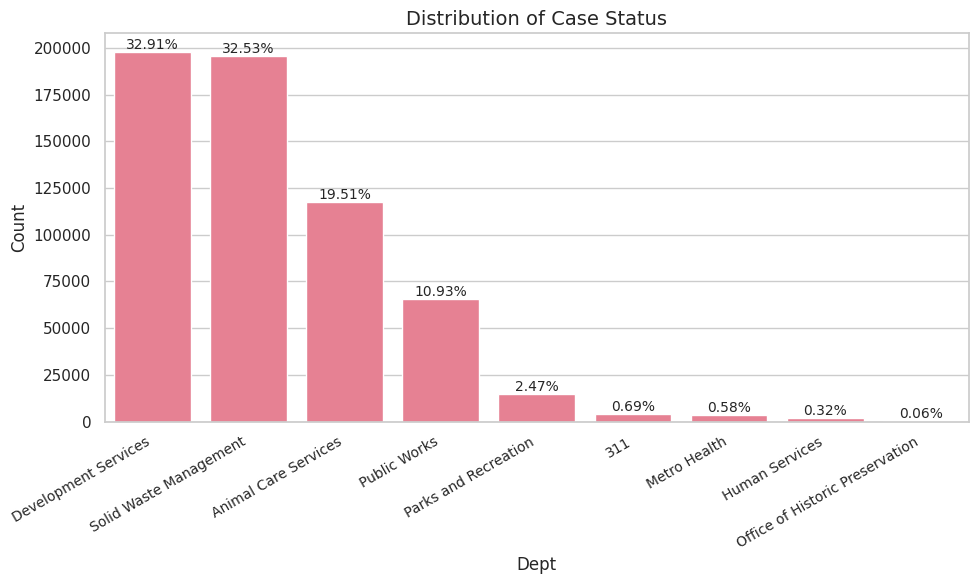

In [ ]:
plot_bar_chart(df, 'Dept', 'Distribution of Case Status')

The data displays the frequency of service requests by department, revealing notable trends. "Development Services" and "Solid Waste Management" emerge as the most frequently cited departments, indicating significant public engagement with these areas. "Animal Care Services" also garners substantial attention, suggesting a community focus on animal welfare. Conversely, departments such as "Public Works," "Parks and Recreation," and "311" receive fewer requests, potentially indicating lower public interaction or fewer reported issues. Insights gleaned from this data can aid in resource allocation, service optimization, and enhancing public engagement strategies.

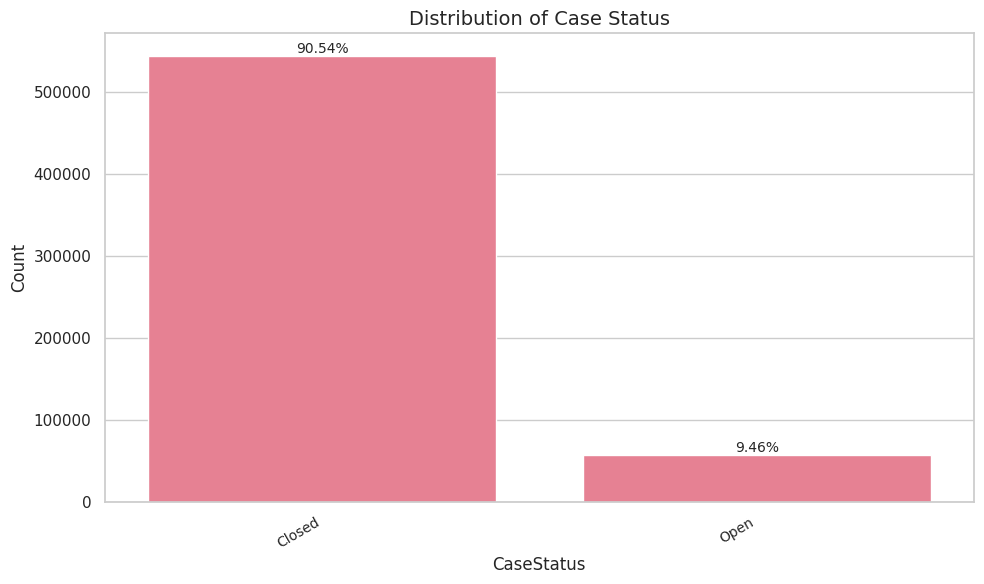

In [ ]:
plot_bar_chart(df, 'CaseStatus', 'Distribution of Case Status')



The data illustrates the status of cases, categorized as "Closed" and "Open." With a significantly higher count in the "Closed" category compared to "Open," it suggests that the majority of cases have been resolved or completed. However, the presence of "Open" cases highlights ongoing or unresolved issues that may require further attention or action. Monitoring and addressing open cases effectively can help ensure timely resolution and enhance constituent satisfaction with service delivery.




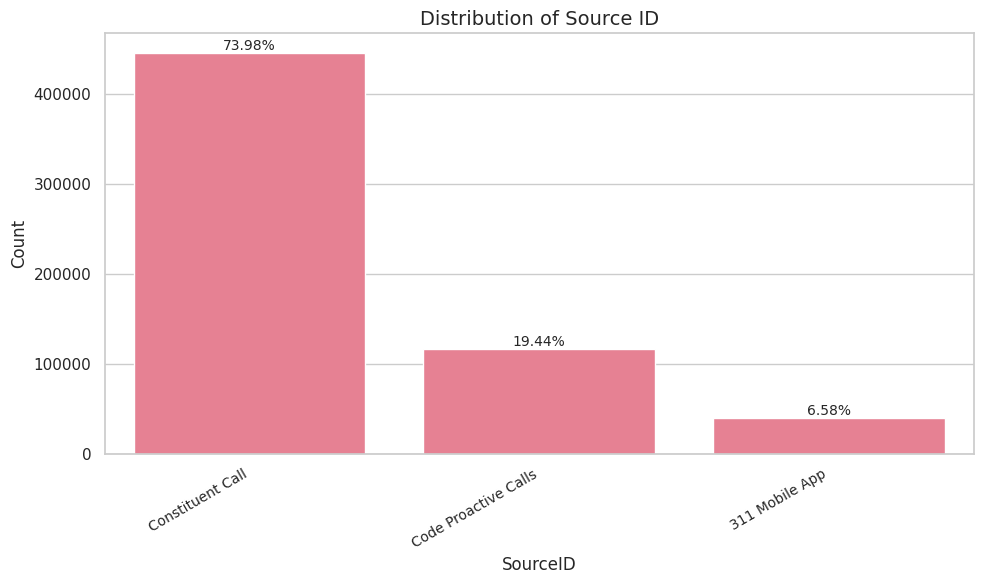

In [ ]:
plot_bar_chart(df, 'SourceID', 'Distribution of Source ID')

The data provides insights into the sources of service requests, indicating how constituents interact with the system. "Constituent Call" emerges as the primary source, with a significantly higher frequency compared to "Code Proactive Calls" and "311 Mobile App." This suggests that constituents predominantly rely on direct calls to report issues. However, the sizable number of "Code Proactive Calls" highlights proactive efforts by the organization to address issues before they are reported. The relatively lower frequency of requests from the "311 Mobile App" may indicate opportunities for promoting and enhancing mobile app usage among constituents. Overall, understanding request sources is crucial for optimizing communication channels and improving constituent engagement.

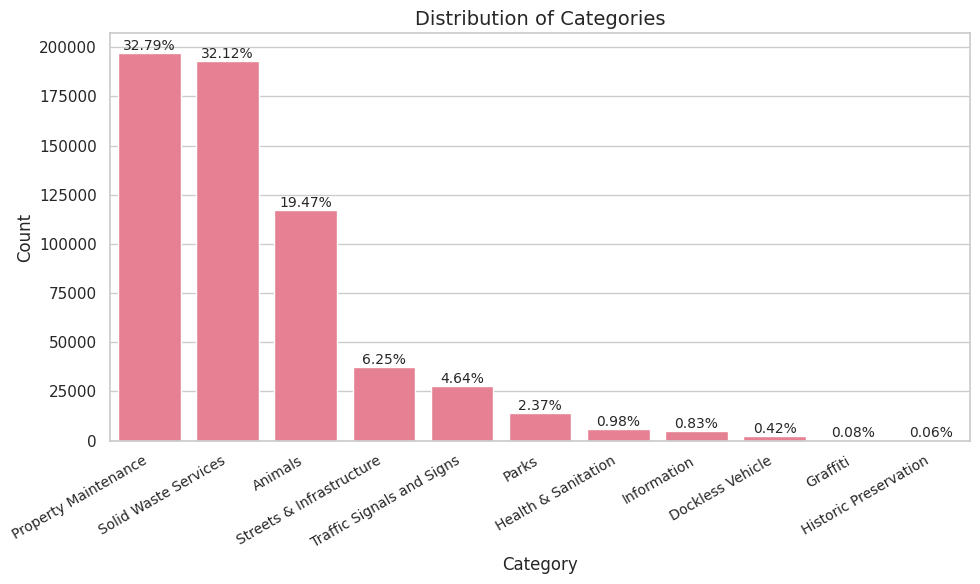

In [ ]:
plot_bar_chart(df, 'Category','Distribution of Categories')

The data shows the frequency of different service request categories, highlighting the most common issues reported. "Property Maintenance" and "Solid Waste Services" stand out as the most frequent categories, indicating these are major concerns within the community. Other categories, such as "Animals" and "Streets & Infrastructure," also appear frequently but to a lesser extent. This suggests a diverse range of issues being addressed by service providers. The dataset could be used to prioritize resource allocation and identify areas for improvement, particularly in less common categories like "Graffiti" and "Historic Preservation

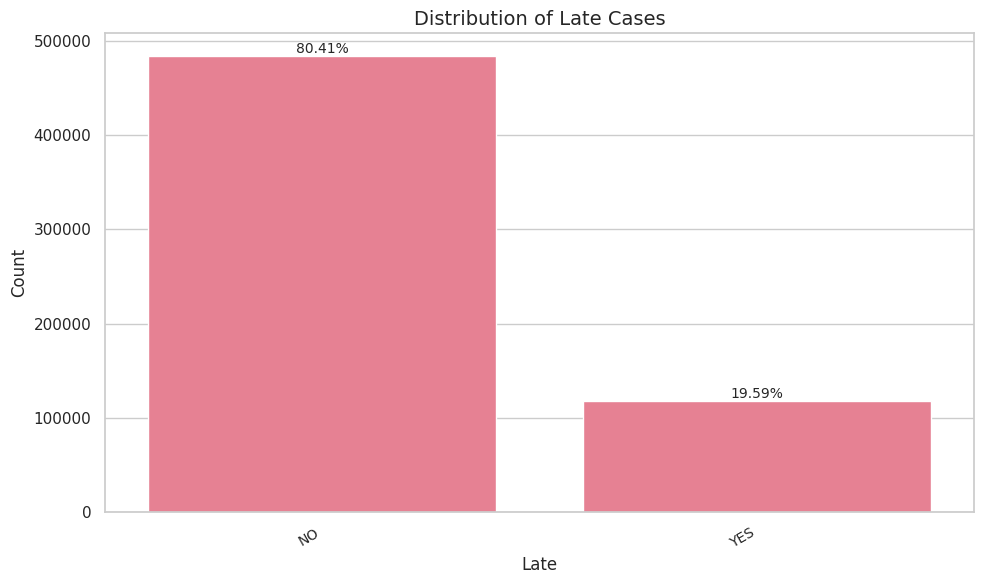

In [ ]:


plot_bar_chart(df,'Late','Distribution of Late Cases')


The data indicates instances of late processes, categorized as "NO" and "YES." With a significantly higher count in the "NO" category compared to "YES," it suggests that most processes are completed on time. However, the presence of "YES" instances highlights a portion of processes that experience delays. Analyzing the reasons behind these delays and implementing strategies to mitigate them could improve overall process efficiency and timeliness.

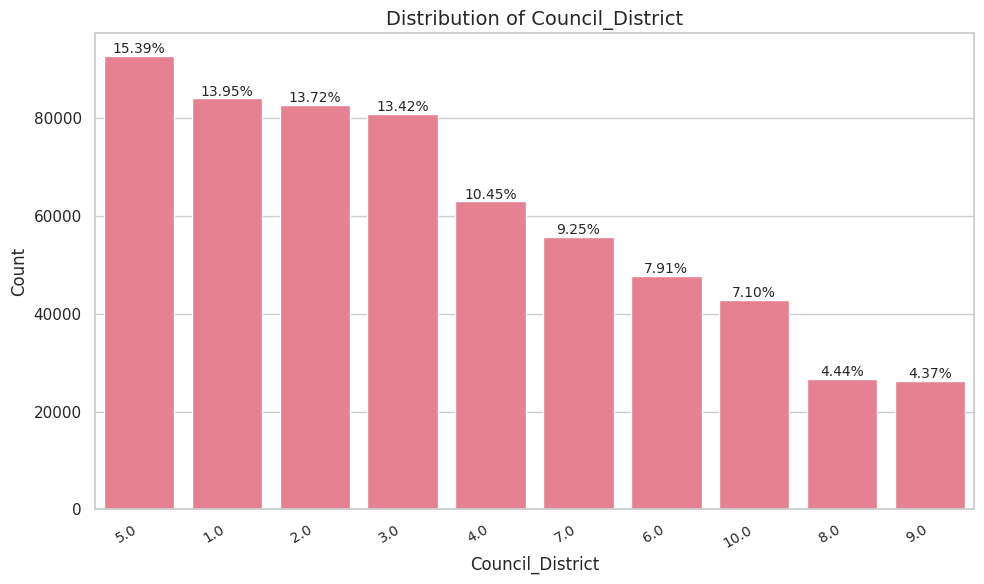

In [ ]:
plot_bar_chart(df,'Council_District','Distribution of Council_District')

The data represents service requests distributed across different council districts. Districts 5, 1, and 2 have the highest request counts, indicating higher levels of constituent engagement or service needs in these areas. Conversely, districts 8 and 9 have comparatively lower request counts, suggesting potentially lower service demand or fewer reported issues. Understanding these variations can inform resource allocation and prioritize service delivery efforts across different council districts

## Extract the zip code

In [ ]:
df.OBJECTDESC.str.extract(r'(\d{5})', expand=True).value_counts(dropna=False)

NaN      90161
78207    29623
78228    29547
78210    25729
78201    24134
         ...  
15909        1
15912        1
15932        1
15942        1
14559        1
Length: 5717, dtype: int64

## The interval time
* Droping the rows with negative intervals

In [ ]:
#ind=df[df['CaseStatus']=='Closed'].index
#df_open=df.drop(ind)

In [ ]:
df['time_interval'] = (df['CLOSEDDATETIME'] - df['OPENEDDATETIME']).dt.days

In [ ]:
print("Services are still under process:",df['time_interval'].isna().sum())


Services are still under process: 56895


In [ ]:

# Apply qcut to the 'time_interval' with only finished jobs  to create quantiles
df['time_interval_quantiles'] = pd.cut(df['time_interval'],
                                        bins=[0, 1, 4, 16,31,365, 1000, 1960],
                                        include_lowest=True,
                                       right=False,
                                       labels=['1 Day', '1-3Days', '4-15Days', '16-30Days','31-364Days' ,'365-1000Days','1001-1959Days'],
                                       )

# Count the frequency of each quantile
quantile_counts = df['time_interval_quantiles'].value_counts(dropna=False).sort_index()
print(quantile_counts)

1 Day            122605
1-3Days          191779
4-15Days         120048
16-30Days         37638
31-364Days        65617
365-1000Days       5031
1001-1959Days      1975
NaN               56898
Name: time_interval_quantiles, dtype: int64


Text(0.5, 1.0, 'Distribution of Time Interval Quantiles')

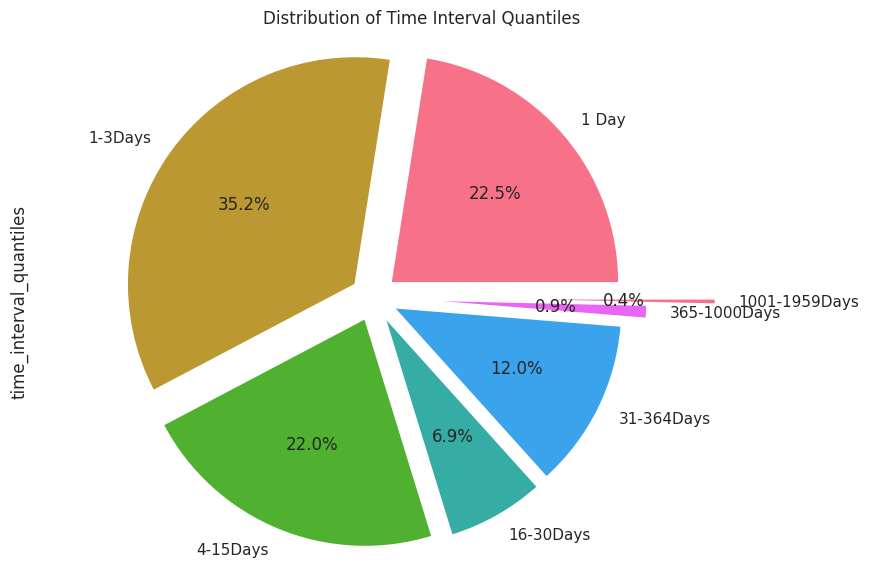

In [ ]:
quantile_counts[:-1].plot(kind='pie', autopct='%1.1f%%', explode=[0.1, 0.1, 0.1, 0.1,0.1,0.2, 0.5])
plt.axis('equal')
plt.title('Distribution of Time Interval Quantiles')
#plt.savefig('/content/drive/MyDrive/SanAntonioCity311/distribution_of_time_interval_quantiles.png')

* Peak Occurrences: The highest frequency is in the "1-3 Days" interval, suggesting that a significant number of processes or events are completed within this timeframe. This could indicate efficiency in handling certain tasks.

* Long-Term Durations: While the majority of occurrences occur within shorter time intervals, there are still notable frequencies in the longer intervals ("31-364 Days", "365-1000 Days", and "1001-1959 Days"). This may indicate processes or events that require longer periods to complete.

* Outliers: The lowest frequencies are in the "365-1000 Days" and "1001-1959 Days" intervals, suggesting that processes or events with durations exceeding 3 years are relatively rare or uncommon.

* Service Level Analysis: Depending on the context, these time intervals could represent service levels, such as response times or resolution times for customer service requests. Analyzing these intervals could provide insights into service performance and areas for improvement.

In [ ]:
df.groupby(['Category','CaseStatus'])['CASEID'].count().unstack().sort_values(by='Open', ascending=False)

CaseStatus,Closed,Open
Category,,
Animals,81151.0,35984.0
Property Maintenance,184109.0,13136.0
Traffic Signals and Signs,25896.0,2040.0
Solid Waste Services,191297.0,1920.0
Information,3273.0,1696.0
Streets & Infrastructure,36500.0,1083.0
Parks,13594.0,670.0
Health & Sanitation,5595.0,287.0
Dockless Vehicle,2431.0,76.0


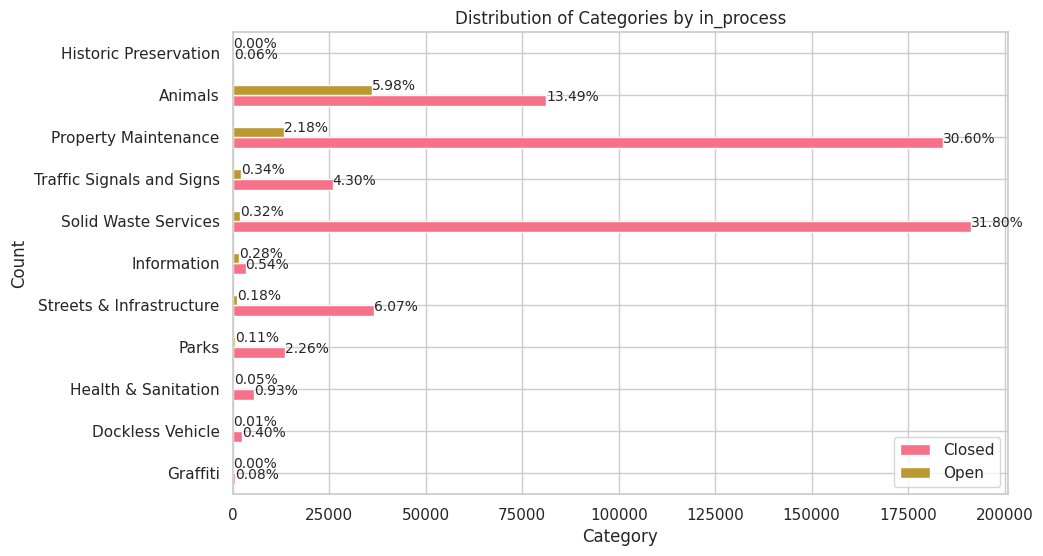

In [ ]:
fig=df.groupby(['Category','CaseStatus'])['CASEID'].count().unstack().sort_values(by='Open').plot(kind='barh',stacked=False,figsize=(10,6))
fig.set_yticklabels(fig.get_yticklabels(), rotation=0)
for p in fig.patches:
    percentage = p.get_width() / len(df)* 100
    fig.annotate(f'{percentage:.2f}%', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left',fontsize=10)
plt.legend(loc='lower right')
plt.ylabel('Count')
plt.xlabel('Category')
plt.title('Distribution of Categories by in_process')
plt.show()


The data shows the number of open cases by category. "Animals" has the highest count of open cases, followed by "Property Maintenance" and "Traffic Signals and Signs." Categories such as "Graffiti" and "Dockless Vehicle" have relatively few open cases. Understanding the distribution of open cases by category can help prioritize resources and address issues efficiently.

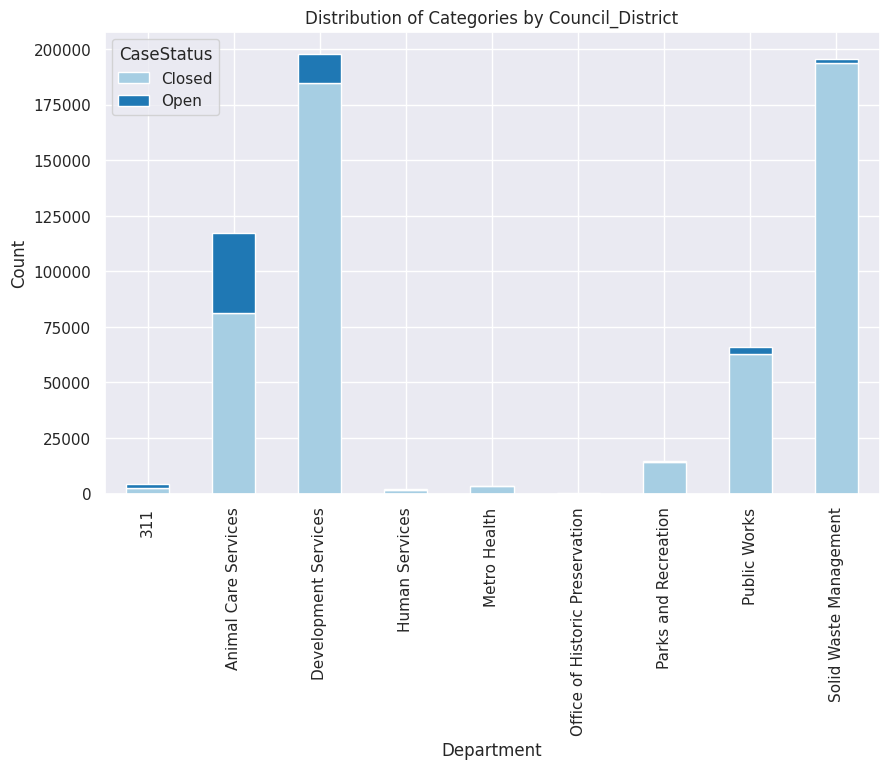

In [ ]:
sns.set(style="darkgrid")
sns.set_palette("Paired")  # Choosing a color palette
df.groupby(['Dept','CaseStatus'])['CASEID'].count().unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.ylabel('Count')
plt.xlabel('Department')
plt.title('Distribution of Categories by Council_District')
plt.show()

## Council_District and Category

In [ ]:
df.groupby(['Council_District','Category'])['CASEID'].count().unstack()

Category,Animals,Dockless Vehicle,Graffiti,Health & Sanitation,Historic Preservation,Information,Parks,Property Maintenance,Solid Waste Services,Streets & Infrastructure,Traffic Signals and Signs
Council_District,,,,,,,,,,,
1.0,12198.0,2277.0,39.0,1248.0,262.0,805.0,1787.0,33498.0,20759.0,5800.0,5222.0
2.0,16195.0,91.0,38.0,626.0,59.0,555.0,2077.0,31481.0,23516.0,5032.0,2868.0
3.0,19147.0,12.0,35.0,710.0,8.0,811.0,1326.0,25951.0,25411.0,4652.0,2678.0
4.0,15036.0,13.0,57.0,442.0,1.0,495.0,1342.0,16989.0,22910.0,3660.0,1929.0
5.0,21839.0,86.0,131.0,576.0,6.0,710.0,2982.0,28967.0,29311.0,4628.0,3333.0
6.0,9760.0,6.0,40.0,475.0,NaN,371.0,1320.0,14788.0,15918.0,2820.0,2074.0
7.0,9343.0,3.0,66.0,487.0,37.0,460.0,1509.0,17841.0,20229.0,3419.0,2236.0
8.0,4181.0,8.0,24.0,470.0,NaN,198.0,820.0,7231.0,9268.0,2265.0,2264.0
9.0,3685.0,2.0,6.0,402.0,1.0,215.0,295.0,7036.0,10370.0,1780.0,2523.0


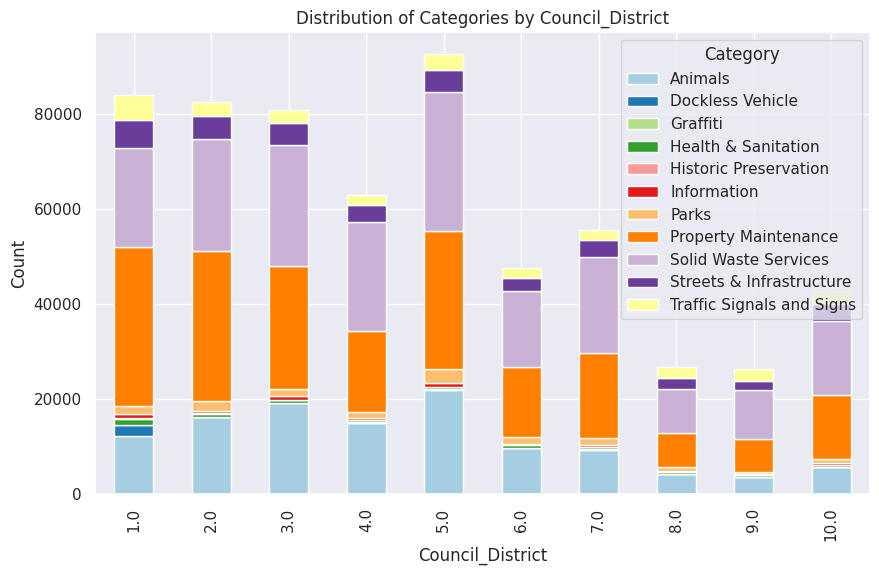

In [ ]:
sns.set(style="darkgrid")
sns.set_palette("Paired")  # Choosing a color palette
df.groupby(['Council_District','Category'])['CASEID'].count().unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.ylabel('Count')
plt.xlabel('Council_District')
plt.title('Distribution of Categories by Council_District')
plt.show()


In Council District 1, the highest number of cases is for "Property Maintenance," followed by "Solid Waste Services" and "Streets & Infrastructure."
Council District 2 also has a high number of cases for "Property Maintenance" and "Solid Waste Services," along with significant numbers for "Animals" and "Traffic Signals and Signs."
Similarly, Council Districts 3, 4, and 5 show patterns of high cases in "Property Maintenance" and "Solid Waste Services," with variations in other categories.
Districts 6, 7, 8, 9, and 10 exhibit similar trends, with "Property Maintenance" and "Solid Waste Services" being prominent categories.
Overall, "Property Maintenance" and "Solid Waste Services" appear to be common categories across all council districts, indicating these are primary areas of concern or service requests within the city.

In [ ]:
# Another way to show the prervious results

Text(0.5, 1.0, 'Distribution of Categories by Council_District')

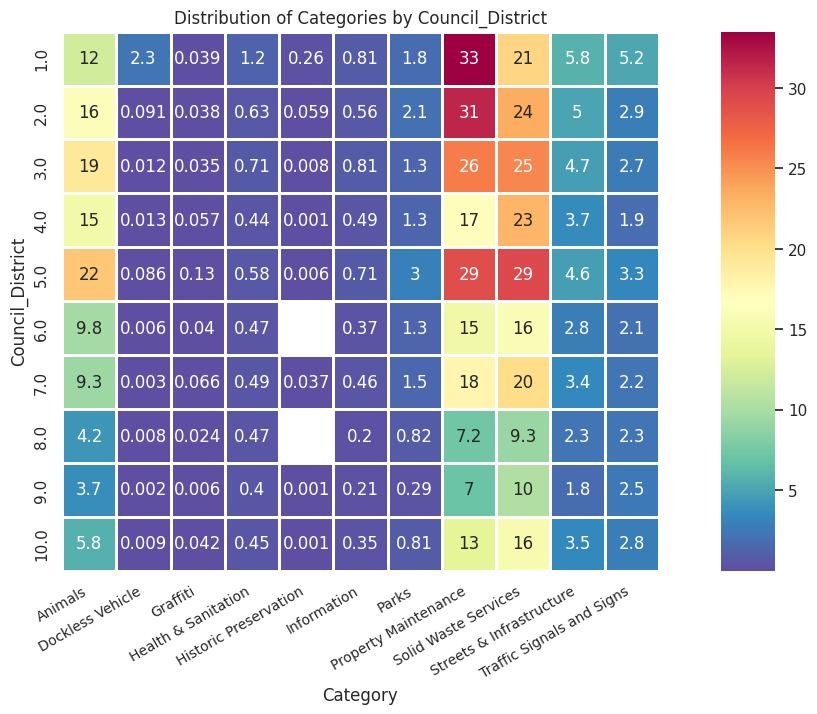

In [ ]:
sns.set(style="white")
sns.set_palette("dark")  # Choosing a color palette
CD_CA=df.groupby(['Council_District','Category'])['CASEID'].count().unstack()
cbar_kws = {'orientation':"vertical", 'pad':0.08, 'aspect':10}
sns.heatmap(CD_CA/1000, cmap='Spectral_r',annot=True,square=False,linewidths=1,cbar_kws=cbar_kws)
plt.xticks(rotation=30,ha='right', fontsize=10)
plt.ylabel('Council_District')
plt.xlabel('Category')
plt.title('Distribution of Categories by Council_District')
#plt.savefig('/content/drive/MyDrive/SanAntonioCity311/distribution_of_categories_by_council_district.png')

Text(0.5, 1.0, 'Distribution of Time Interval by Category')

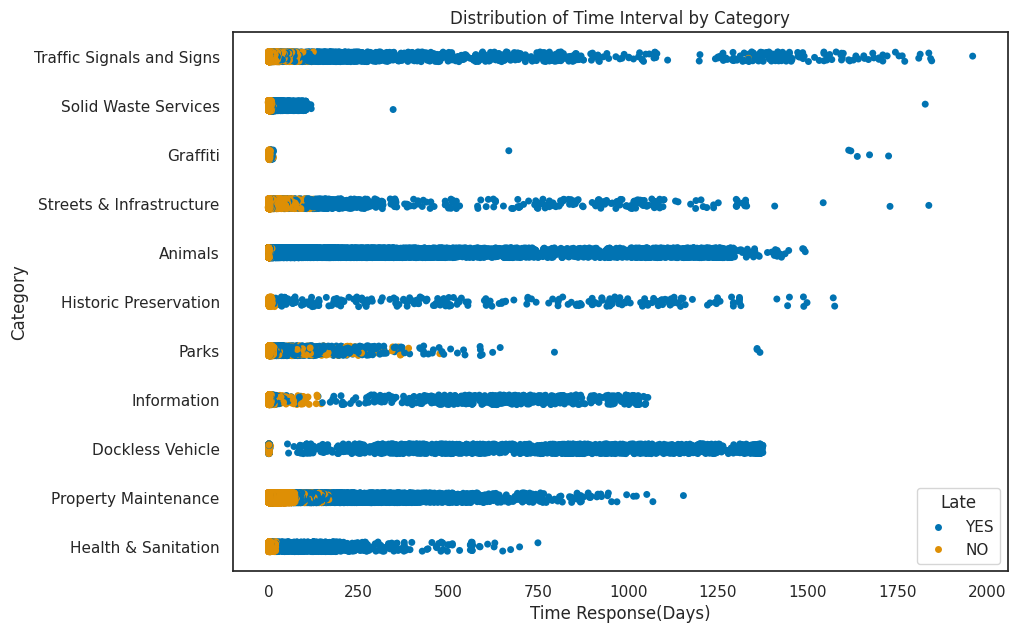

In [ ]:
sns.stripplot(data=df,x='time_interval',y='Category',hue='Late',palette='colorblind')
plt.xlabel('Time Response(Days)')
plt.ylabel('Category')
plt.title('Distribution of Time Interval by Category')
#plt.savefig('/content/drive/MyDrive/SanAntonioCity311/distribution_of_time_interval_by_category.png')

Traffic Signals and Signs has the highest response time followed by street and infrastructure, then by Graffiti.

## Temporal analysis of 311 service

In [ ]:
df.groupby(df['OPENEDDATETIME'].dt.year)['CASEID'].count().reset_index().rename(columns={'CASEID':'Count'})

,OPENEDDATETIME,Count
0,2017,1
1,2018,21
2,2019,582
3,2020,5512
4,2021,4280
5,2022,16116
6,2023,486728
7,2024,88351


Text(0.5, 1.0, 'Distribution of Cases by Year')

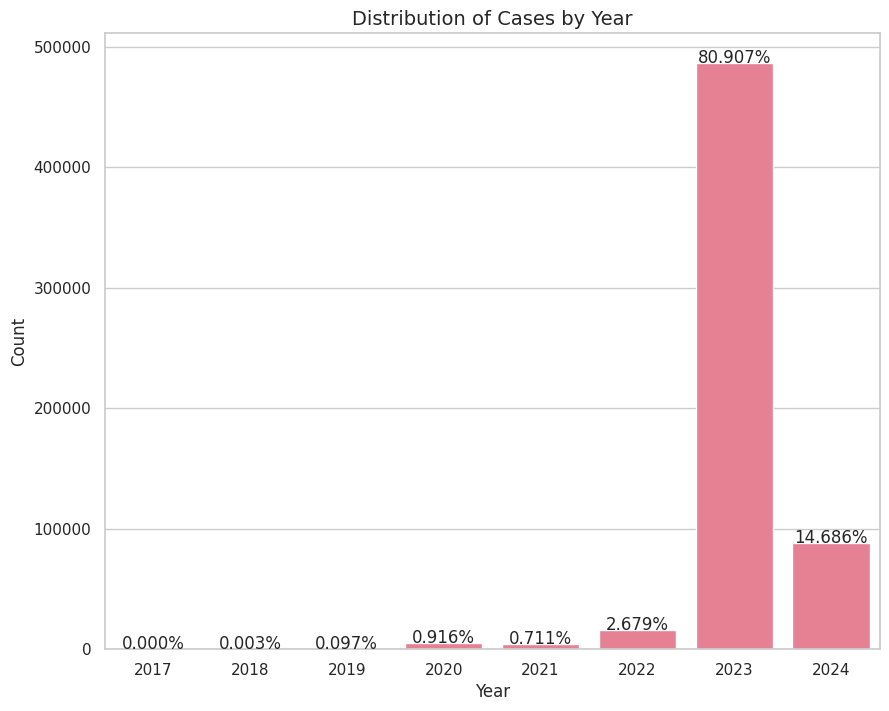

In [ ]:
sns.set(style="whitegrid")
sns.set_palette("husl")
plt.figure(figsize=(10, 8))
# Grouping data and plotting line chart
ax = sns.barplot(data=df.groupby(df['OPENEDDATETIME'].dt.year)['CASEID'].count())

# Add percentages on top of each marker
total_cases = df['CASEID'].count()
for idx, count in enumerate(df.groupby(df['OPENEDDATETIME'].dt.year)['CASEID'].count()):
    percentage = count / total_cases * 100
    ax.text(idx, count, f'{percentage:.3f}%', ha='center',fontsize=12)

# Adding labels and title
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Distribution of Cases by Year', fontsize=14)

# Displaying the plot
#plt.savefig('/content/drive/MyDrive/SanAntonioCity311/distribution_of_cases_by_year.png')


In 2017, only 1 case was opened.
The number of cases opened increased steadily over the next few years, with 21 cases in 2018 and 582 cases in 2019.
A significant jump in cases occurred in 2020, with 5,512 cases opened.
This trend continued in 2021 and 2022, with 4,280 and 16,116 cases opened, respectively.
The highest number of cases opened was in 2023, with 486,725 cases.
In 2024, there was a notable decrease in the number of cases opened, with 88,351 cases.

In [ ]:
df.groupby(df['OPENEDDATETIME'].dt.month)['CASEID'].count()

OPENEDDATETIME
1     49328
2     53511
3     56975
4     52502
5     61402
6     56386
7     48054
8     48947
9     43740
10    47121
11    43207
12    40418
Name: CASEID, dtype: int64

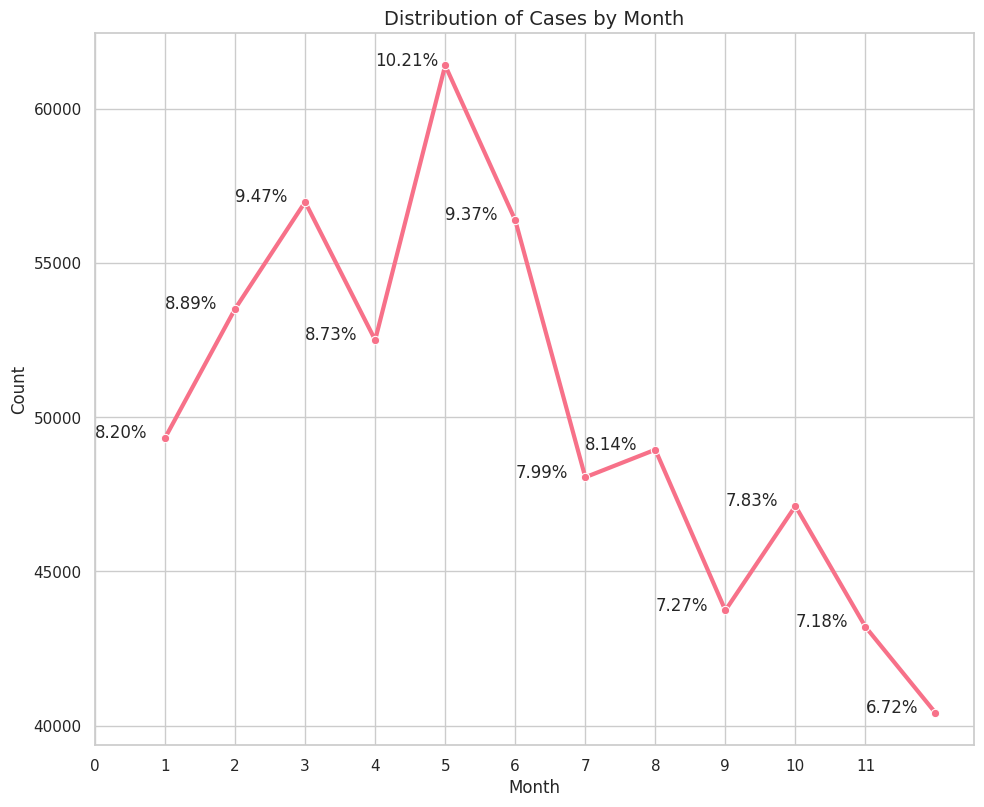

In [ ]:
# Setting style and palette
sns.set(style="whitegrid")
sns.set_palette("husl")
plt.figure(figsize=(10, 8))

# Grouping data and plotting line chart
ax=sns.lineplot(data=df.groupby([df['OPENEDDATETIME'].dt.month])['CASEID'].count(), marker='o')

# Add percentages on top of each marker
for idx, count in enumerate(df.groupby(df['OPENEDDATETIME'].dt.month)['CASEID'].count()):
    ax.text(idx, count, f'{count/sum(df.groupby(df["OPENEDDATETIME"].dt.month)["CASEID"].count())*100:.2f}%', )
#Adjusting x-axis ticks to show all ticks
ax.set_xticks(range(len(df.groupby([df['OPENEDDATETIME'].dt.month])['CASEID'].count())))
#ax.set_xticklabels([calendar.month_abbr[i+1] for i in range(12)], rotation=45)

# Making the line thicker
ax.lines[0].set_linewidth(3)

# Displaying the plot
plt.tight_layout()
# Adding labels and title
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Distribution of Cases by Month', fontsize=14)

# Displaying the plot
#plt.savefig('/content/drive/MyDrive/SanAntonioCity311/distribution_of_cases_by_month.png')
plt.show()

    month       pct
0       1       NaN
1       2  0.084800
2       3  0.064734
3       4 -0.078508
4       5  0.169517
5       6 -0.081691
6       7 -0.147767
7       8  0.018583
8       9 -0.106380
9      10  0.077298
10     11 -0.083063
11     12 -0.064550


Text(0.5, 1.0, 'Percentage Change in the Count of Cases by Month')

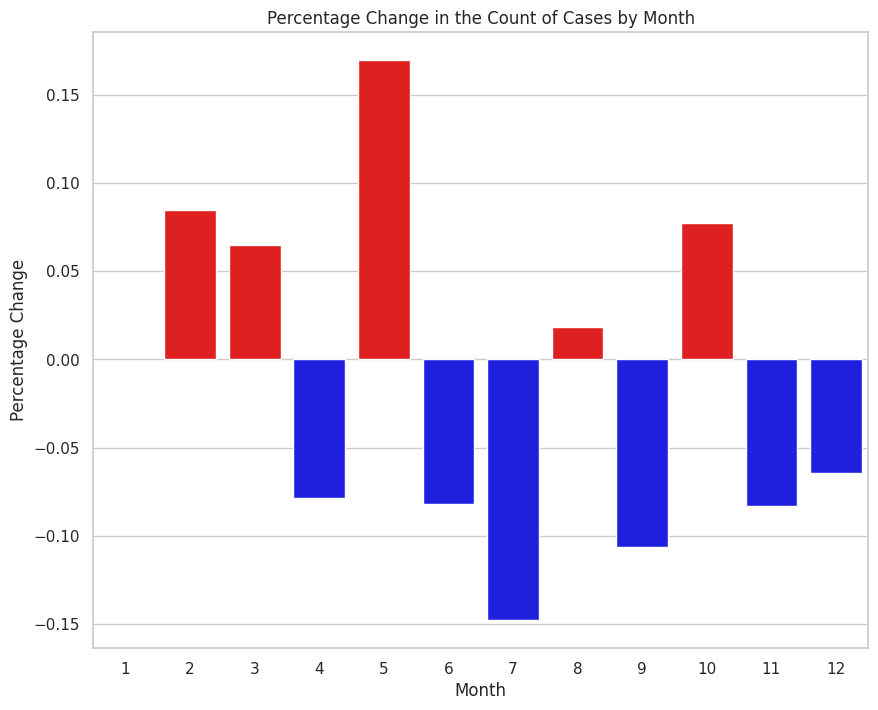

In [ ]:
sns.set(style="whitegrid")
sns.set_palette("husl")
plt.figure(figsize=(10, 8))  # Fixed the whitespace issue

# Calculating the percentage change in the count of 'CASEID' grouped by month.
# It computes the percentage change from one month to the next month.
pct = df.groupby([df['OPENEDDATETIME'].dt.month])['CASEID'].count().pct_change().reset_index().rename(columns={'OPENEDDATETIME': 'month', 'CASEID': 'pct'})
print(pct)

# Fixed the color assignment logic
colors = ['blue' if x < 0 else 'red' for x in pct['pct']]
ax2 = sns.barplot(data=pct, y='pct', x='month',hue='month', palette=colors, order=range(1, 13),legend=False)
plt.ylabel('Percentage Change')
plt.xlabel('Month')
plt.title('Percentage Change in the Count of Cases by Month')

Peak Months: May stands out as the month with the highest number of requests, followed closely by March and June. Understanding the reasons behind these peaks, such as specific events, weather conditions, or annual cycles, can help anticipate and prepare for increased service demand during these periods.

Off-Peak Months: Conversely, months like December and September exhibit lower request counts. Exploring the factors contributing to these quieter periods, such as holidays, seasonal trends, or decreased activity, can help optimize resource allocation and staffing levels during times of lower demand.

In [ ]:
dd=df.groupby([df['OPENEDDATETIME'].dt.month,'Category'])['CASEID'].count().unstack().rename(index={'OPENEDDATETIME':'month'})
dd

Category,Animals,Dockless Vehicle,Graffiti,Health & Sanitation,Historic Preservation,Information,Parks,Property Maintenance,Solid Waste Services,Streets & Infrastructure,Traffic Signals and Signs
OPENEDDATETIME,,,,,,,,,,,
1,11336,223,29,554,29,355,1242,15161,15165,3036,2198
2,10593,187,39,612,27,329,1580,18914,15561,3369,2300
3,10828,247,59,482,38,471,1167,17081,19664,3154,3784
4,9569,227,34,339,21,401,1025,16939,16682,4535,2730
5,10419,163,70,498,22,457,1326,22140,19424,4288,2595
6,9392,250,55,484,42,403,1316,20081,18647,3496,2220
7,8372,300,42,396,37,433,1162,16823,15734,2909,1846
8,9138,216,27,448,27,491,1141,16200,16114,2860,2285
9,8812,182,34,578,27,445,1186,13192,14446,2623,2215


<ipython-input-91-1e06f2835cb8>:6: UserWarning: 
The markers list has fewer values (1) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax1=sns.lineplot(data=df.groupby([df['OPENEDDATETIME'].dt.month,'Category'])['CASEID'].count().unstack(),markers='o')


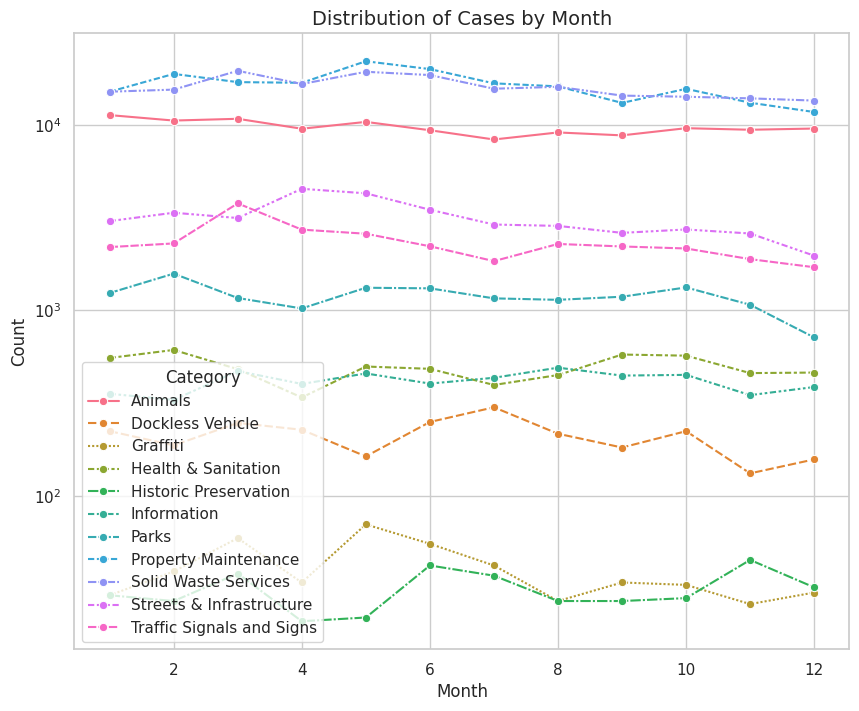

In [ ]:
# Setting style and palette
sns.set(style="whitegrid")
sns.set_palette("husl")
plt.figure(figsize=(10, 8))

ax1=sns.lineplot(data=df.groupby([df['OPENEDDATETIME'].dt.month,'Category'])['CASEID'].count().unstack(),markers='o')
ax1.set_yscale('log')
# Adding labels and title
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Distribution of Cases by Month', fontsize=14)

# Displaying the plot
plt.show()

Animals: The number of animal-related service requests remains relatively consistent throughout the year, with a slight decrease in the winter months (December to February).

Dockless Vehicle: Service requests related to dockless vehicles show a fluctuating pattern, with higher counts observed in the warmer months (March to October) and lower counts in the colder months (November to February).

Graffiti: Graffiti-related service requests vary but generally show peaks during the spring and summer months (March to August), possibly due to increased outdoor activities during this period.

Health & Sanitation: Service requests related to health and sanitation exhibit consistent patterns throughout the year, with slightly higher counts during the summer months, which could be attributed to seasonal factors like increased waste generation.

Historic Preservation: Requests related to historic preservation show relatively stable counts throughout the year, with occasional peaks observed in the summer months.

Information: Service requests for information services remain relatively steady, with no significant seasonal trends observed.

Parks: Requests related to parks show higher counts during the spring and summer months (March to August), corresponding to periods of increased outdoor recreational activities.

Property Maintenance: Property maintenance-related service requests vary but generally exhibit higher counts during the warmer months (March to October), possibly due to increased outdoor property upkeep during this time.

Solid Waste Services: Service requests related to solid waste services show a consistent pattern throughout the year, with slightly higher counts observed in the summer months.

Streets & Infrastructure: Requests related to streets and infrastructure maintenance vary but generally show peaks during the warmer months, corresponding to periods of increased road construction and maintenance activities.

Traffic Signals and Signs: Service requests for traffic signals and signs maintenance vary but often show higher counts during the warmer months when road usage is typically higher.

<Figure size 1000x800 with 0 Axes>

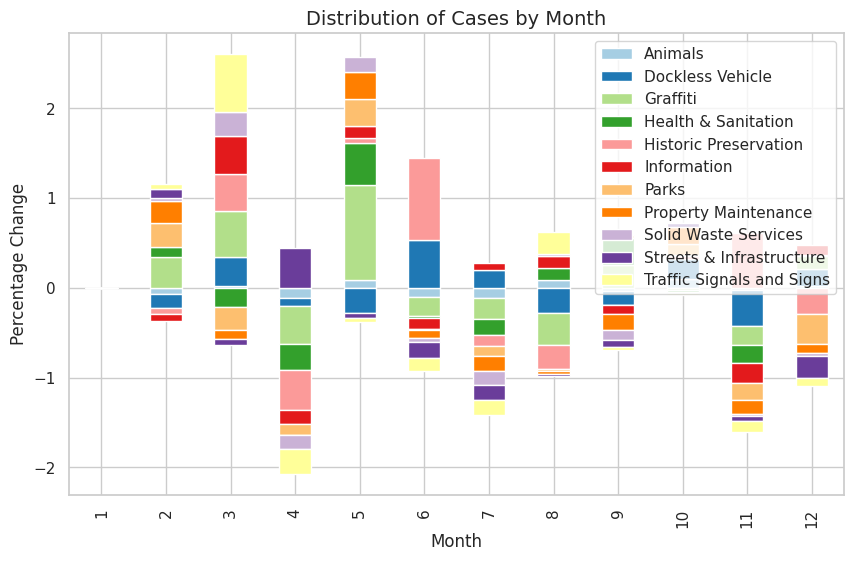

In [ ]:
# Setting style and palette
sns.set(style="whitegrid")
sns.set_palette("Paired")
plt.figure(figsize=(10, 8))
df.groupby([df['OPENEDDATETIME'].dt.month,'Category'])['CASEID'].count().unstack().pct_change().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.ylabel('Percentage Change',fontsize=12)
plt.xlabel('Month',fontsize=12)
plt.title('Distribution of Cases by Month', fontsize=14)
plt.legend(loc='upper right')

# Displaying the plot
plt.show()


#

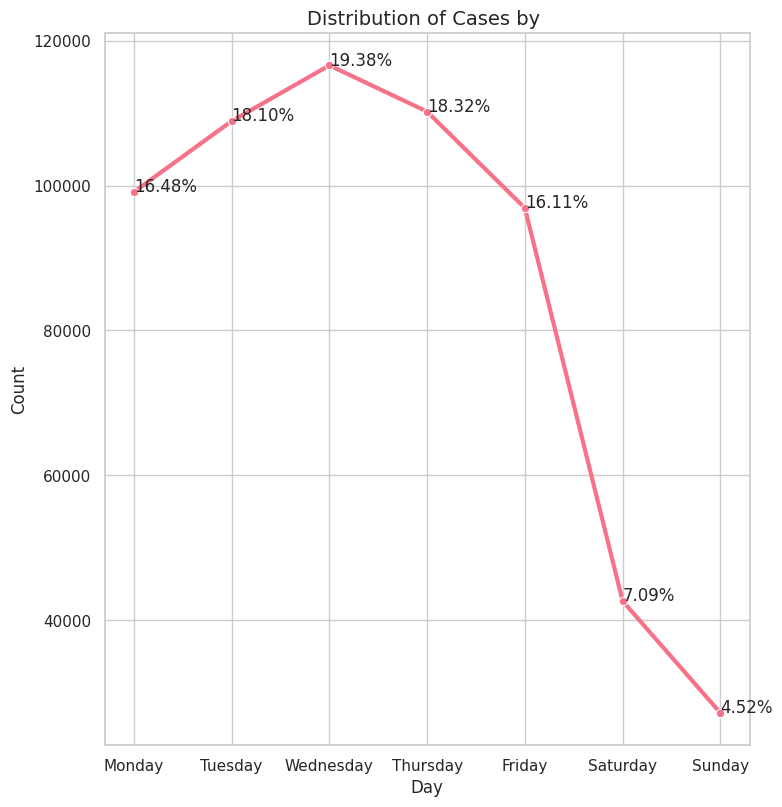

In [ ]:
# Setting style and palette
sns.set(style="whitegrid")
sns.set_palette("husl")
plt.figure(figsize=(8, 8))

# Grouping data and plotting line chart
ax=sns.lineplot(data=df.groupby([df['OPENEDDATETIME'].dt.day_of_week])['CASEID'].count(), marker='o')

# Add percentages on top of each marker
for idx, count in enumerate(df.groupby(df['OPENEDDATETIME'].dt.day_of_week)['CASEID'].count()):
    ax.text(idx, count, f'{count/sum(df.groupby(df["OPENEDDATETIME"].dt.day_of_week)["CASEID"].count())*100:.2f}%', )
#Adjusting x-axis ticks to show all ticks
ax.set_xticks(range(len(df.groupby([df['OPENEDDATETIME'].dt.day_of_week])['CASEID'].count())))
#ax.set_xticklabels([calendar.month_abbr[i+1] for i in range(12)], rotation=45)

# Making the line thicker
ax.lines[0].set_linewidth(3)

# Displaying the plot
plt.tight_layout()
# Adding labels and title
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.title('Distribution of Cases by ', fontsize=14)
names=['Monday',
'Tuesday',
'Wednesday',
'Thursday',
'Friday',
'Saturday',
'Sunday']
plt.xticks(range(len(names)), names)
# Displaying the plot
#plt.savefig('/content/drive/MyDrive/SanAntonioCity311/distribution_of_cases_by_month.png')
plt.show()

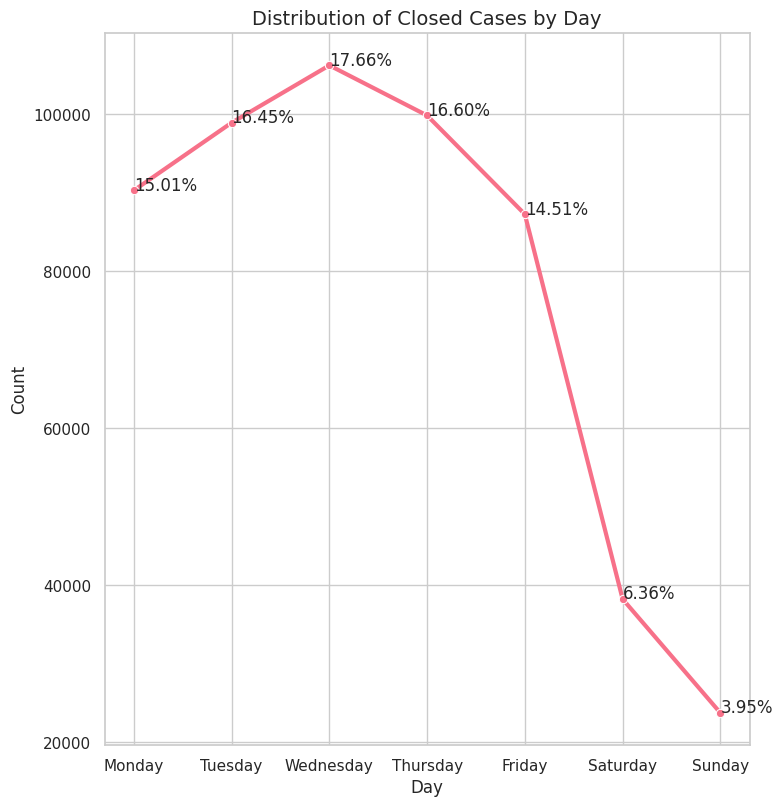

In [ ]:
# Setting style and palette
sns.set(style="whitegrid")
sns.set_palette("husl")
plt.figure(figsize=(8, 8))

# Grouping data and plotting line chart

gb=df[df.CaseStatus=='Closed'].groupby([df['OPENEDDATETIME'].dt.day_of_week])['CASEID'].count()
ax=sns.lineplot(data=gb, marker='o')

# Add percentages on top of each marker
for idx, count in enumerate(gb):
    ax.text(idx, count, f'{count/sum(df.groupby(df["OPENEDDATETIME"].dt.day_of_week)["CASEID"].count())*100:.2f}%', )
#Adjusting x-axis ticks to show all ticks
ax.set_xticks(range(len(df.groupby([df['OPENEDDATETIME'].dt.day_of_week])['CASEID'].count())))
#ax.set_xticklabels([calendar.month_abbr[i+1] for i in range(12)], rotation=45)

# Making the line thicker
ax.lines[0].set_linewidth(3)

# Displaying the plot
plt.tight_layout()
# Adding labels and title
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.title('Distribution of Closed Cases by Day', fontsize=14)
names=['Monday',
'Tuesday',
'Wednesday',
'Thursday',
'Friday',
'Saturday',
'Sunday']
plt.xticks(range(len(names)), names)
# Displaying the plot
#plt.savefig('/content/drive/MyDrive/SanAntonioCity311/distribution_of_cases_by_month.png')
plt.show()

Midweek Surge: Wednesday emerges as the day with the highest count of service requests, indicating a midweek surge in demand for services. This could be attributed to various factors such as ongoing issues, routine service requests, or specific events or circumstances that lead to increased demand on Wednesdays.

Weekly Pattern: Despite Wednesday having the highest count, Monday still retains significance as the beginning of the workweek and may have a substantial number of service requests. However, Wednesday surpasses Monday in terms of service demand, suggesting that midweek issues or needs may be more pronounced in this dataset.

Text(0.5, 1.0, 'Distribution of Cases by Month')

<Figure size 1500x800 with 0 Axes>

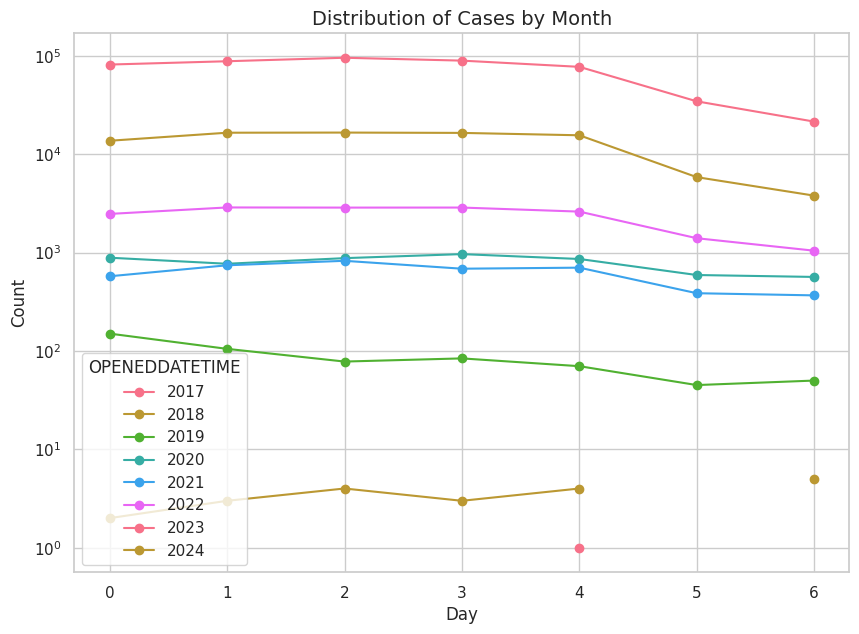

In [ ]:
plt.figure(figsize=(15, 8))
# Grouping data and plotting line chart
df.groupby([df['OPENEDDATETIME'].dt.year,df['OPENEDDATETIME'].dt.day_of_week])['CASEID'].count().unstack().T.plot(kind='line', marker='o')
# Adding labels and title
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.yscale('log')
plt.title('Distribution of Cases by Month', fontsize=14 )


We notice consistent pattern over years.

## The Holidays effect

Text(0.5, 1.0, 'Distribution of Cases by Day')

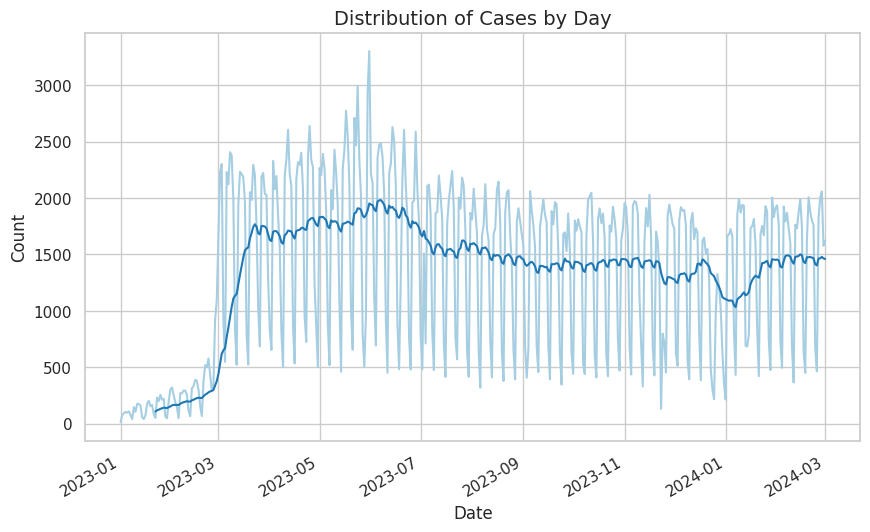

In [ ]:
sns.set(style="whitegrid")
sns.set_palette("Paired")
plt.figure(figsize=(15, 8))
# Set 'OPENEDDATETIME' as the index
df_time=df.set_index('OPENEDDATETIME')
bd = pd.tseries.offsets.CustomBusinessDay(n=1,
                                          weekmask="Mon Tue Wed Thu Fri")
#pd.tseries.offsets.BusinessDay(2)
# Resample the DataFrame by day and apply mean aggregation
daily_count = df_time.resample('D').count().loc['2023-01-01':,'CASEID']

sns.lineplot(data=daily_count)
daily_count.rolling(window=22).mean().plot(kind='line', figsize=(10, 6))
plt.xlabel('Date',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Distribution of Cases by Day',fontsize=14)
#plt.savefig('/content/drive/MyDrive/SanAntonioCity311/daily_count.png')


In [ ]:
# Resample the DataFrame by day and apply mean aggregation
print('the daily average', round(daily_count.rolling(window=22).mean().mean(),2))


the daily average 1377.63


In [ ]:
import pandas as pd
from pandas.tseries.holiday import Holiday, USFederalHolidayCalendar

# Define the country for which you want to get holiday dates
# For example, 'US' for United States, 'UK' for United Kingdom
country_code = 'US'


In [ ]:
holidays_2023=USFederalHolidayCalendar().holidays(start='2023-01-01', end='2024-3-1',return_name=True).rename_axis('Date').rename('holiday').reset_index()


2023-01-02 00:00:00
2023-01-16 00:00:00
2023-02-20 00:00:00
2023-05-29 00:00:00
2023-06-19 00:00:00
2023-07-04 00:00:00
2023-09-04 00:00:00
2023-10-09 00:00:00
2023-11-10 00:00:00
2023-11-23 00:00:00
2023-12-25 00:00:00
2024-01-01 00:00:00
2024-01-15 00:00:00
2024-02-19 00:00:00


Text(0.5, 1.0, 'Distribution of Cases by (Day,Week,Month)')

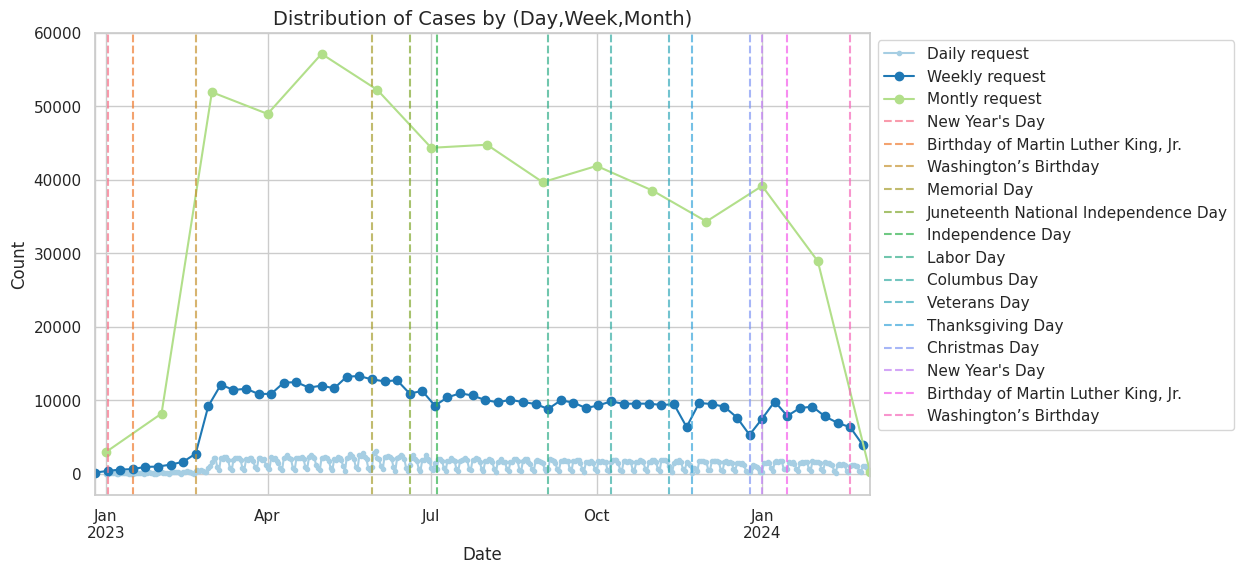

In [ ]:
sns.set(style="whitegrid")
sns.set_palette("Paired")
plt.figure(figsize=(15, 8))
# Set 'OPENEDDATETIME' as the index
df_time=df.set_index('OPENEDDATETIME')
#pd.tseries.offsets.BusinessDay(2)
# Resample the DataFrame by day and apply mean aggregation
daily_response = df_time.resample('d').count().loc['2023-01-01':,'time_interval']
daily_response.plot.line(figsize=(10, 6),marker='.',label='Daily request')
weekly_response = df_time.resample('w').count().loc['2023-01-01':,'time_interval']
weekly_response.plot.line(figsize=(10, 6),marker='o',label='Weekly request')
monthly_response = df_time.resample('m').count().loc['2023-01-01':,'time_interval']
monthly_response .plot.line(figsize=(10, 6),marker='o',label='Montly request')
# Define a list of colors for holidays
holiday_colors = sns.color_palette('husl', n_colors=len(holidays_2023))
for i, (Date,holiday) in enumerate(zip(holidays_2023.Date,holidays_2023.holiday)):
    print(Date)
    plt.axvline(x=Date, color=holiday_colors[i], linestyle='--', alpha=0.7,label=holiday)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Count',fontsize=12)
# Get the handles and labels for the lines
lines, labels = plt.gca().get_legend_handles_labels()

# Put the legend outside the figure
plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Distribution of Cases by (Day,Week,Month)',fontsize=14)



In [ ]:
holiday_df=pd.DataFrame({'Holiday_date':holidays_2023.Date,'Holiday_Names':holidays_2023.holiday})
df['holidays']=df_time.index.isin(holiday_df['Holiday_date'].values).astype(int)

### The holiday effect on the total amount of service requests can manifest in several ways:     

Decreased Activity: During major holidays or festive seasons, there may be a decrease in the total number of service requests. This could be due to reduced business hours, fewer people accessing public services, or individuals prioritizing holiday activities over reporting issues.

Shift in Request Types: Certain types of service requests may decrease during holidays, such as those related to non-essential services or routine maintenance. Conversely, requests related to emergency services or public safety may see a temporary increase due to holiday-related incidents or events.

Delayed Reporting: Service requests that would typically be reported on holidays may experience delays, with individuals waiting until after the holiday period to report issues. This could lead to a surge in service requests immediately following holidays as backlogged reports are processed.

Seasonal Variations: Some holidays coincide with specific seasonal changes or events, such as increased tourism, outdoor activities, or extreme weather conditions. These factors can influence the types and frequency of service requests during holiday periods.

Community Engagement: Holidays may also foster increased community engagement and civic participation, leading to a temporary uptick in service requests as residents take advantage of the holiday period to address local issues or concerns.

## Weather Effect:


In [ ]:
!pip install meteostat

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

In [ ]:
location = Point(29.5, -98.5, 300)
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 3, 1)
data = Daily(location, start_date, end_date)
data = data.fetch()

In [ ]:
data.head(2)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2023-01-01,16.5,8.0,25.3,0.0,0.0,117.0,7.9,NaN,1011.6,NaN
2023-01-02,21.6,17.5,27.5,0.3,0.0,167.0,14.4,NaN,1006.7,NaN


In [ ]:
data['rain']=np.select([data['prcp']>0,data['prcp']<0],[1,0])
data['tavg_f']=data['tavg'].apply(lambda x: x*1.8+32)

Text(0.5, 1.0, 'Distribution of Cases by (Day,Week,Month,Tempreture(F))')

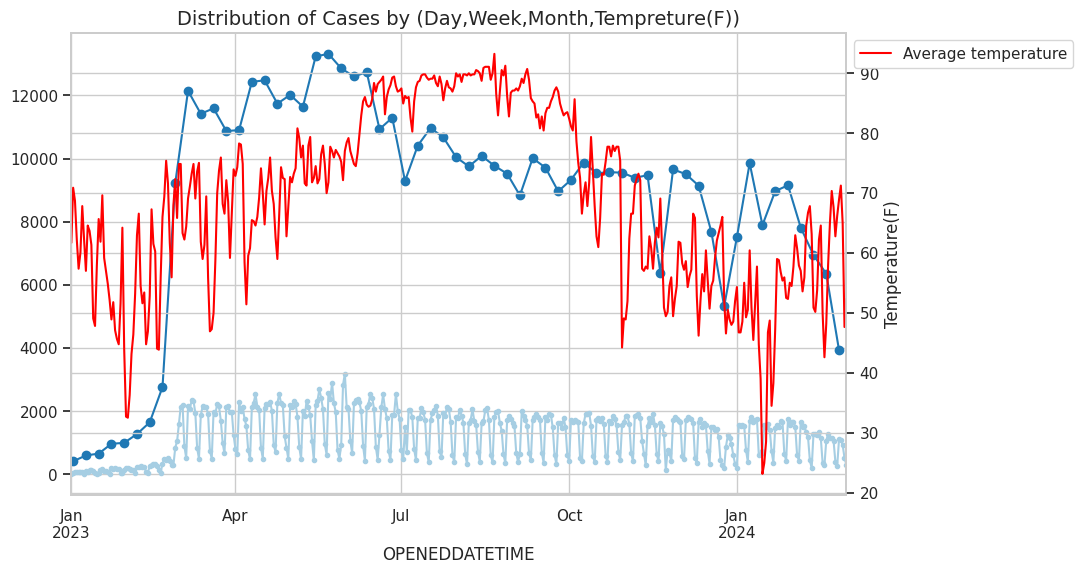

In [ ]:
# Resample the DataFrame by day and apply mean aggregation
daily_response.plot.line(figsize=(10, 6),marker='.',label='Daily request')
weekly_response.plot.line(figsize=(10, 6),marker='o',label='Weekly request')
#monthly_response = df_time.resample('m').count().loc['2023-01-01':,'time_interval'].plot.line(figsize=(10, 6),marker='^',label='Montly request')
# Define a list of colors for holidays
lx=plt.twinx()
data['tavg_f'].plot.line(ax=lx,color='red',label='Average temperature')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Count',fontsize=12)
lx.set_ylabel('Temperature(F)',fontsize=12)
# Get the handles and labels for the lines
lines, labels = plt.gca().get_legend_handles_labels()
# Put the legend outside the figure
plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Distribution of Cases by (Day,Week,Month,Tempreture(F))',fontsize=14)

Text(0.5, 1.0, 'Distribution of Cases by (Day,Week,Month,Precipitation)')

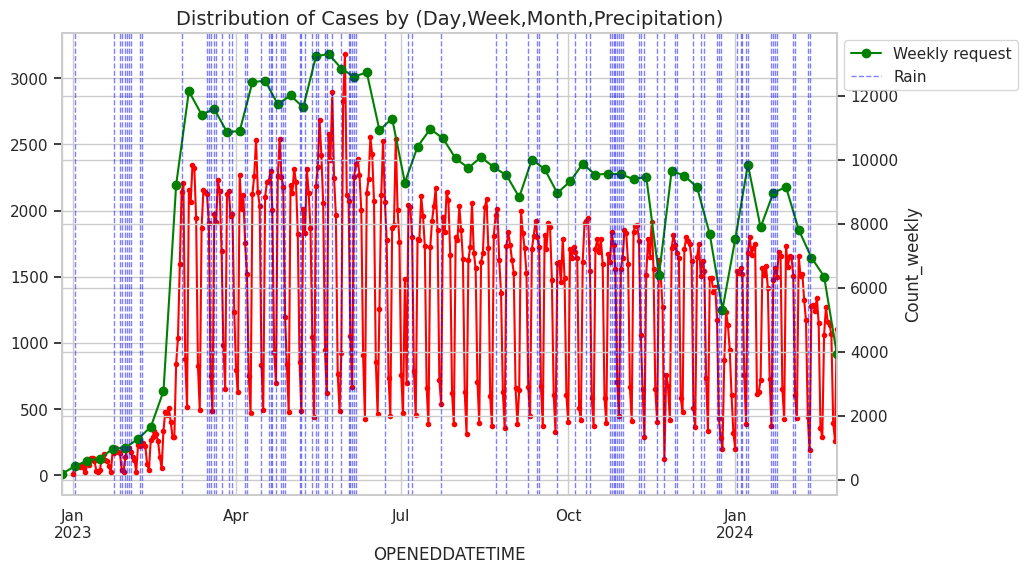

In [ ]:
# Resample the DataFrame by day and apply mean aggregation

daily_response.plot.line(figsize=(10, 6),marker='.',
                                                                                            color='red',label='Daily request')

lx=plt.twinx()
weekly_response.plot.line(ax=lx,figsize=(10, 6),
                                                                                             color='green',marker='o',label='Weekly request')
#monthly_response = df_time.resample('m').count().loc['2023-01-01':,'time_interval'].plot.line(figsize=(10, 6),marker='^',label='Montly request')
# Define a list of colors for holidays

for center,row in data[['rain']].iterrows():
  if row['rain']==1:
    plt.axvline(x=center,color='blue',label='Rain', linestyle='--', alpha=0.5,linewidth=1)



plt.xlabel('Date',fontsize=12)
plt.ylabel('Count',fontsize=12)
lx.set_ylabel('Count_weekly',fontsize=12)
# Get the handles and labels for the lines
lines, labels = plt.gca().get_legend_handles_labels()
# Put the legend outside the figure
plt.legend(lines[:2], labels[:2], loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Distribution of Cases by (Day,Week,Month,Precipitation)',fontsize=14)

In [ ]:
## merge data and df
df_merged=df.merge(data[['rain','tavg_f']],left_on='OPENEDDATETIME',right_index=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575079 entries, 26660 to 606060
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Category                 575079 non-null  object        
 1   CASEID                   575079 non-null  int64         
 2   OPENEDDATETIME           575079 non-null  datetime64[ns]
 3   SLA_Date                 575079 non-null  datetime64[ns]
 4   CLOSEDDATETIME           533626 non-null  datetime64[ns]
 5   Late                     575079 non-null  object        
 6   Dept                     575079 non-null  object        
 7   REASONNAME               575079 non-null  object        
 8   TYPENAME                 575079 non-null  object        
 9   CaseStatus               575079 non-null  object        
 10  SourceID                 575079 non-null  object        
 11  OBJECTDESC               575079 non-null  object        
 12  Council_Dist

In [ ]:
#
df_merged_group=df_merged.groupby(['OPENEDDATETIME','Category']).agg(count=('CASEID','count'),rain=('rain','mean'),tavg_f=('tavg_f','mean')
,response_time=('time_interval','median')).reset_index()
df_merged_group.head(2)

,OPENEDDATETIME,Category,count,rain,tavg_f,response_time
0,2023-01-01,Animals,9,0.0,61.7,250.5
1,2023-01-01,Dockless Vehicle,2,0.0,61.7,319.0


In [ ]:
df_merged_group.groupby(['rain','Category'])[['count','response_time']].median().unstack().T

rain                                       0.0     1.0
              Category                                
count         Animals                    255.0  258.00
              Dockless Vehicle             2.0    2.00
              Graffiti                     2.0    2.00
              Health & Sanitation         14.0   12.00
              Historic Preservation        1.0    1.00
              Information                  9.0    9.00
              Parks                       37.0   28.00
              Property Maintenance       511.0  497.00
              Solid Waste Services       612.0  585.50
              Streets & Infrastructure    93.0  105.00
              Traffic Signals and Signs   65.0   70.00
response_time Animals                      0.0    0.00
              Dockless Vehicle             1.0    1.00
              Graffiti                     3.0    4.00
              Health & Sanitation          5.0    6.00
              Historic Preservation        5.0    5.50
              Information                  3.0    3.00
              Parks                        5.0    5.25
              Property Maintenance         7.0    7.00
              Solid Waste Services         2.0    2.00
              Streets & Infrastructure     1.0    2.00
              Traffic Signals and Signs    1.0    1.00

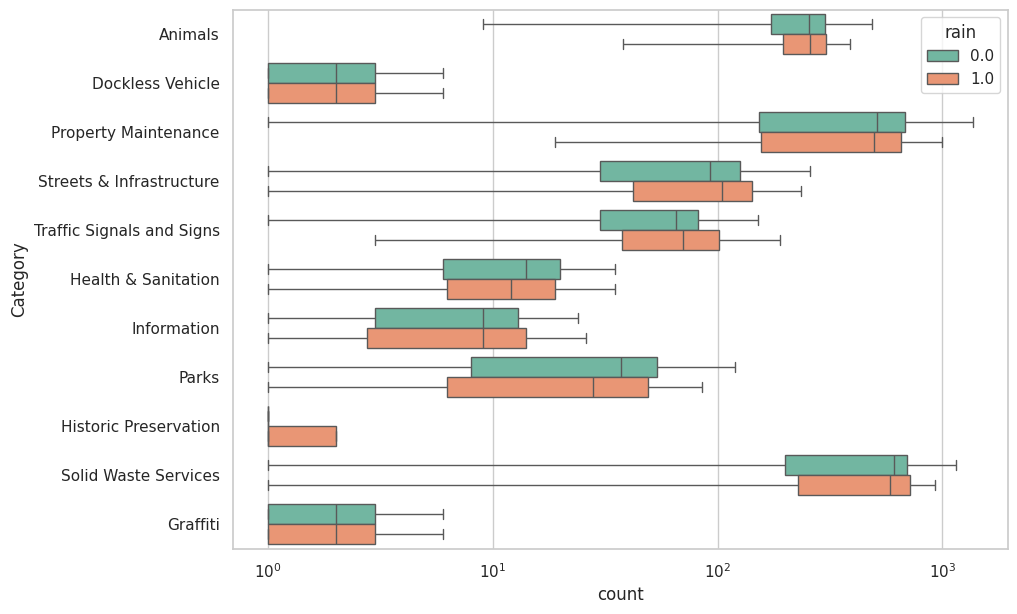

In [ ]:
sns.boxplot(data=df_merged_group,y='Category',x='count',hue='rain',palette='Set2',showfliers=False)
plt.xscale(value='log')

### In some categories, such as Animals, Dockless Vehicle, Graffiti, and Historic Preservation, the median number of requests appears to be consistent across both conditions, as the median values are the same or very close.
For categories like Parks, Property Maintenance, Solid Waste Services, and Streets & Infrastructure, there seems to be a difference between the median number of requests on rainy days compared to non-rainy days. For example, the median number of requests for Property Maintenance is higher on non-rainy days compared to rainy days.
The magnitude and direction of the differences vary across categories, indicating that weather conditions may have different effects on the volume of requests for different types of services

### the effect of rainy days and average temperature on the 311 request.



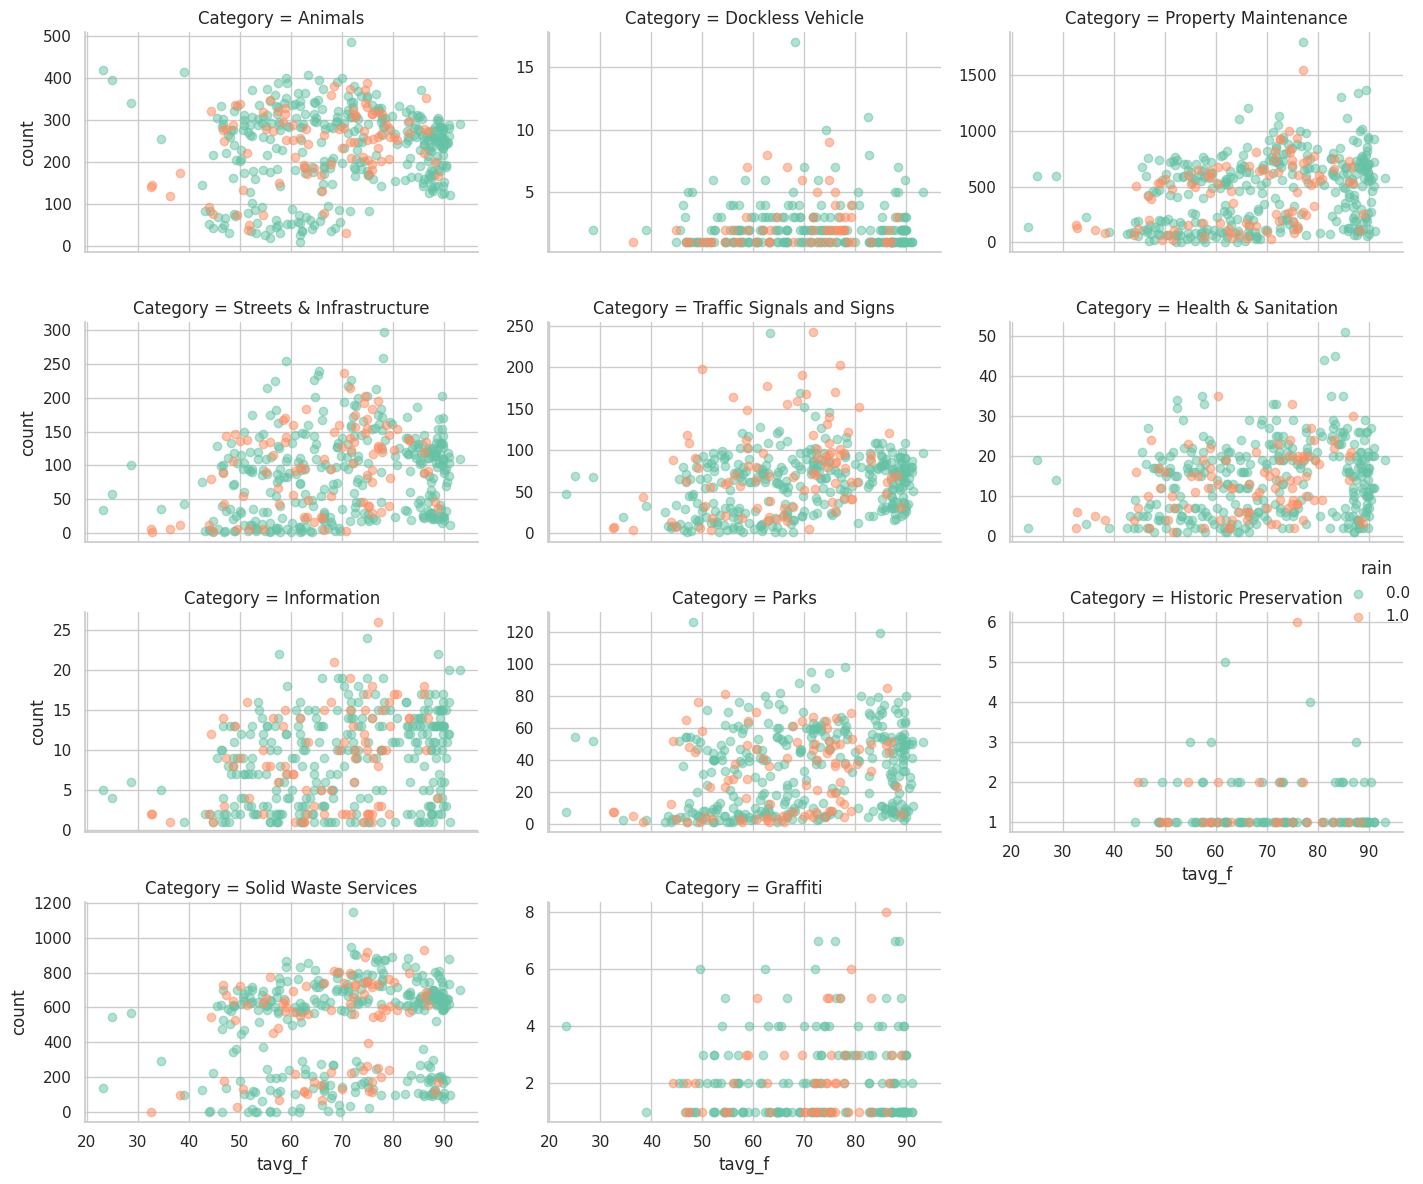

In [ ]:
sns.lmplot(x='tavg_f',y='count',data=df_merged_group,col='Category',
           hue='rain',fit_reg=False,scatter_kws={'alpha':0.5}
           ,height=3,aspect=1.5,col_wrap=3,legend=True,palette='Set2',facet_kws={'sharey':False,'legend_out':True})
#plt.yscale('log')
plt.tight_layout()

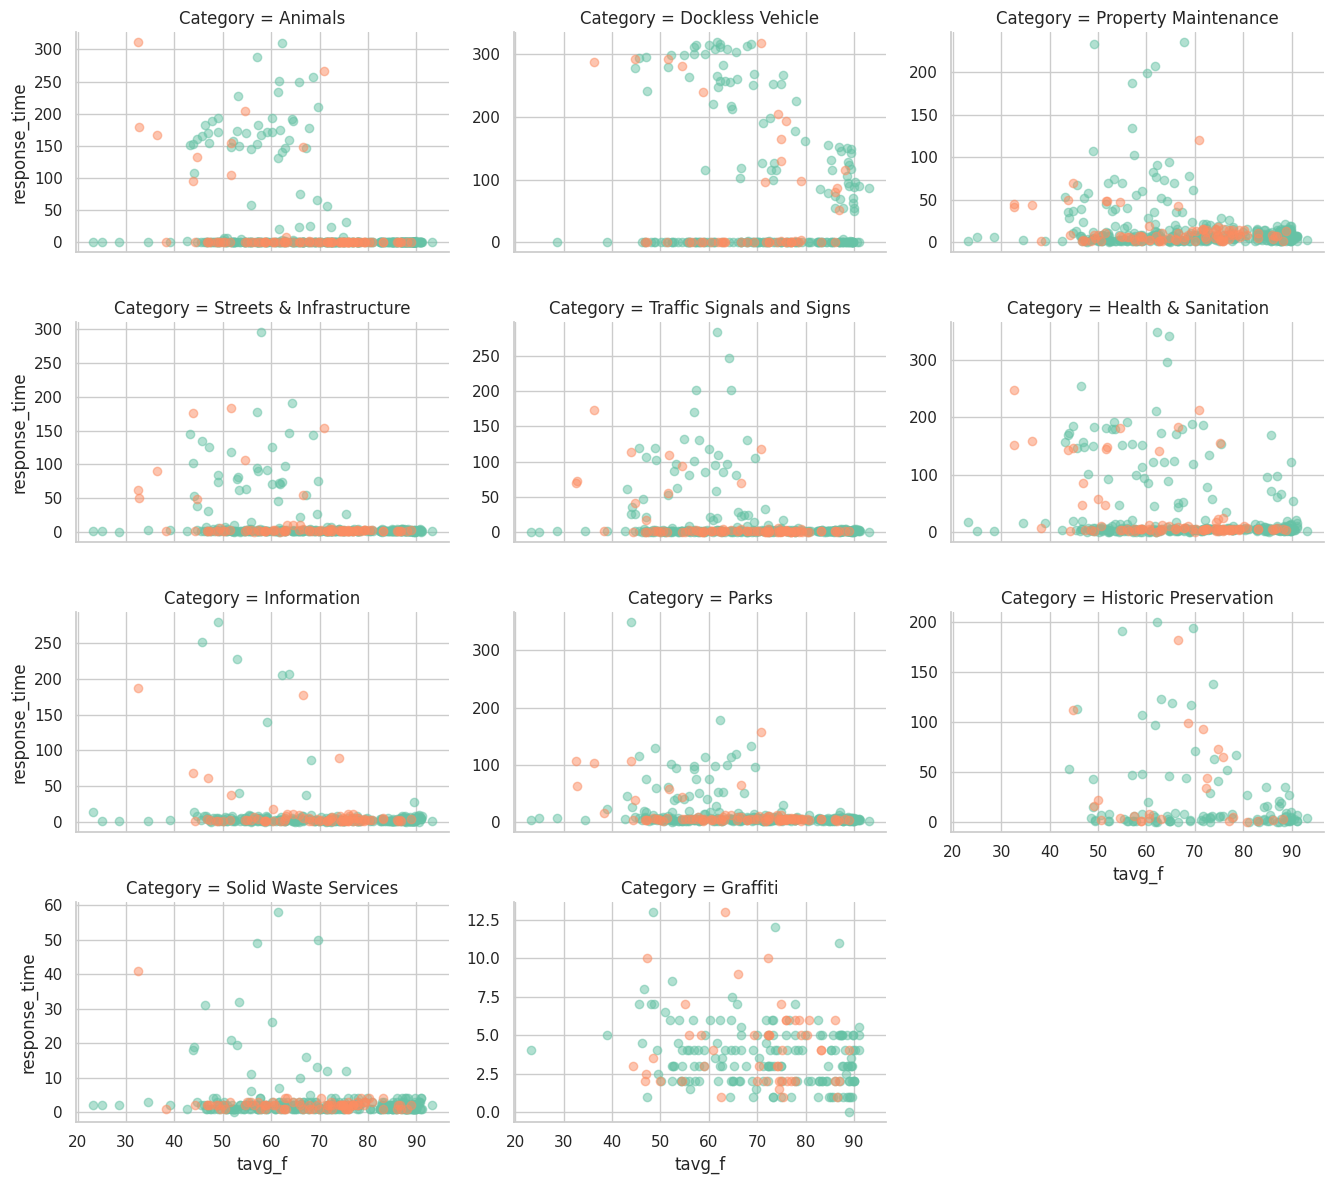

In [ ]:
sns.lmplot(x='tavg_f',y='response_time',data=df_merged_group,col='Category',
           hue='rain',fit_reg=False,scatter_kws={'alpha':0.5}
           ,height=3,aspect=1.5,col_wrap=3,legend=False,palette='Set2',facet_kws={'sharey':False,'legend_out':True})
#plt.yscale('log')
plt.tight_layout()

## Output csv file

In [ ]:
output="/content/drive/MyDrive/SanAntonioCity311/311_clean.csv"
df_merged.to_csv(output)